In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel("Data.xlsx")

In [3]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,Null,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,Null,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,Null,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,Null,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,Null,13302


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [5]:
data.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [6]:
data.shape

(10683, 11)

In [7]:
data.duplicated().sum()

220

In [8]:
airline_value_count = data["Airline"].value_counts()
airline_value_count

Airline
Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: count, dtype: int64

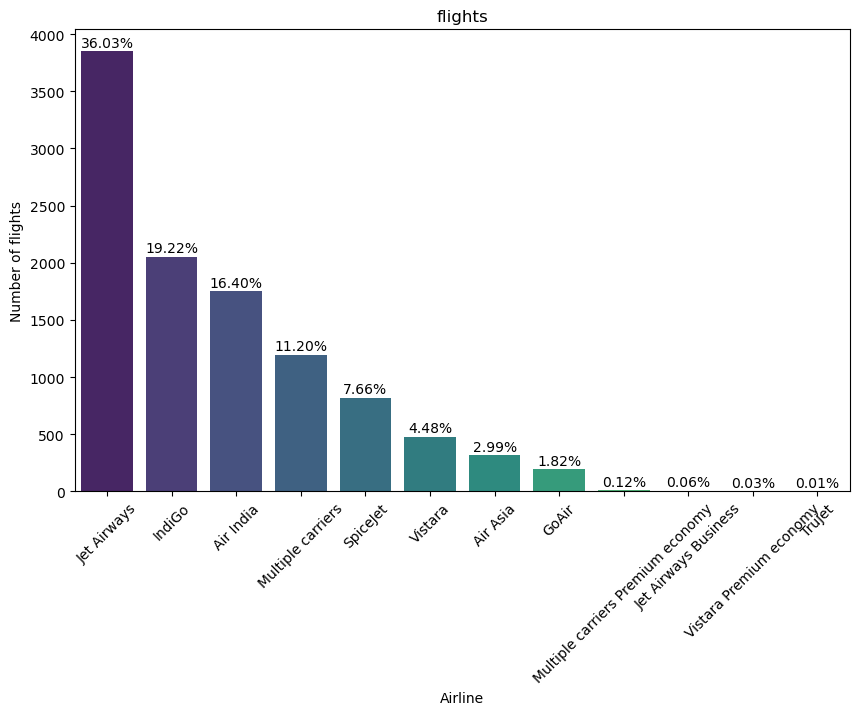

In [9]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x=airline_value_count.index , y =airline_value_count.values,palette='viridis')
plt.title("flights")
total = len(data)
for p in ax.patches:
    height = p.get_height()
    percentage = f'{height/total*100:.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 6), textcoords='offset points')
plt.xlabel("Airline")
plt.ylabel("Number of flights")
plt.xticks(rotation = 45)
plt.show()

Jet Airways has the most flights 36.03%
and also if we combine flights of Jet Airway, IndiGo and Air India we can see they hold 71% flights in the indian market

In [11]:
stops_counts = data["Total_Stops"].value_counts()
stops_counts

Total_Stops
1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: count, dtype: int64

In [12]:
# Grouping by Airline and Total_Stops, then counting the occurrences
stops_per_airline = data.groupby(['Airline', 'Total_Stops']).size().unstack(fill_value=0)

# Display the result
print(stops_per_airline)

Total_Stops                        1 stop  2 stops  3 stops  4 stops  non-stop
Airline                                                                       
Air Asia                              129        9        0        0       181
Air India                             540      756       37        1       417
GoAir                                 102        0        0        0        92
IndiGo                                793       19        0        0      1241
Jet Airways                          2535      691        0        0       623
Jet Airways Business                    4        2        0        0         0
Multiple carriers                    1145       43        8        0         0
Multiple carriers Premium economy      13        0        0        0         0
SpiceJet                              148        0        0        0       670
Trujet                                  1        0        0        0         0
Vistara                               215        0  

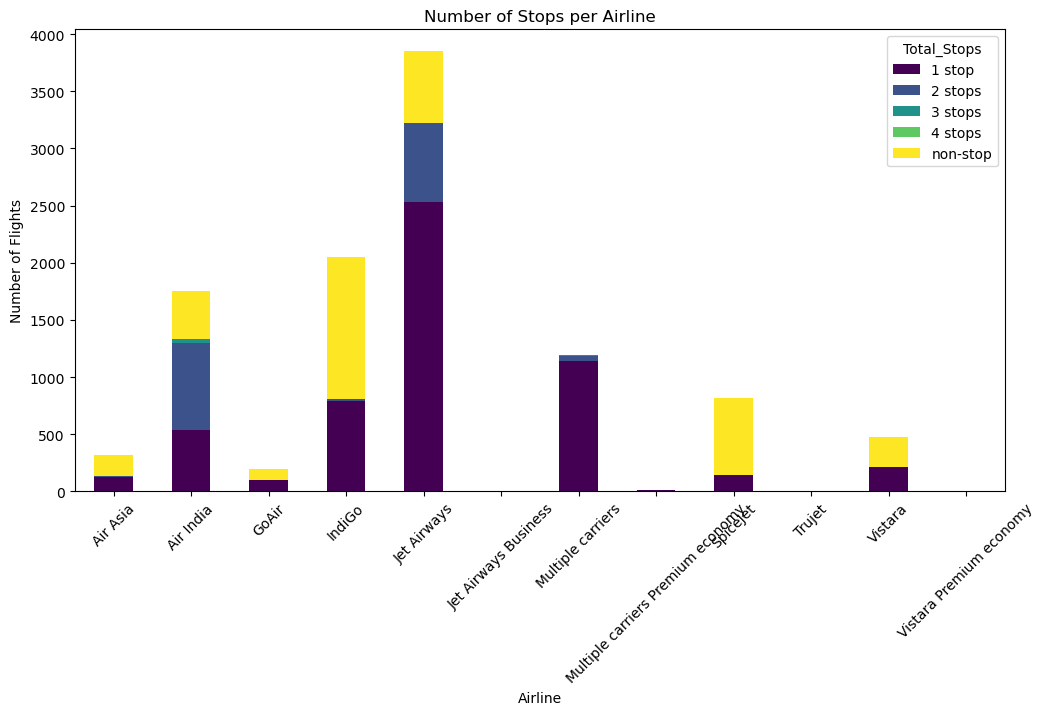

In [13]:
# Visualizing the number of stops per airline
stops_per_airline.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Number of Stops per Airline')
plt.xlabel('Airline')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.show()

Most of airline has mostly 1 stop and Non-stop flights 

Air Asia, IndiGo and spicejet has more number of Non-stop flights while Jet Ariways, Multiple carriers and GoAir has more number of 1-stop flights

Air India is the only airline which has 3-stop and 4-stop flights

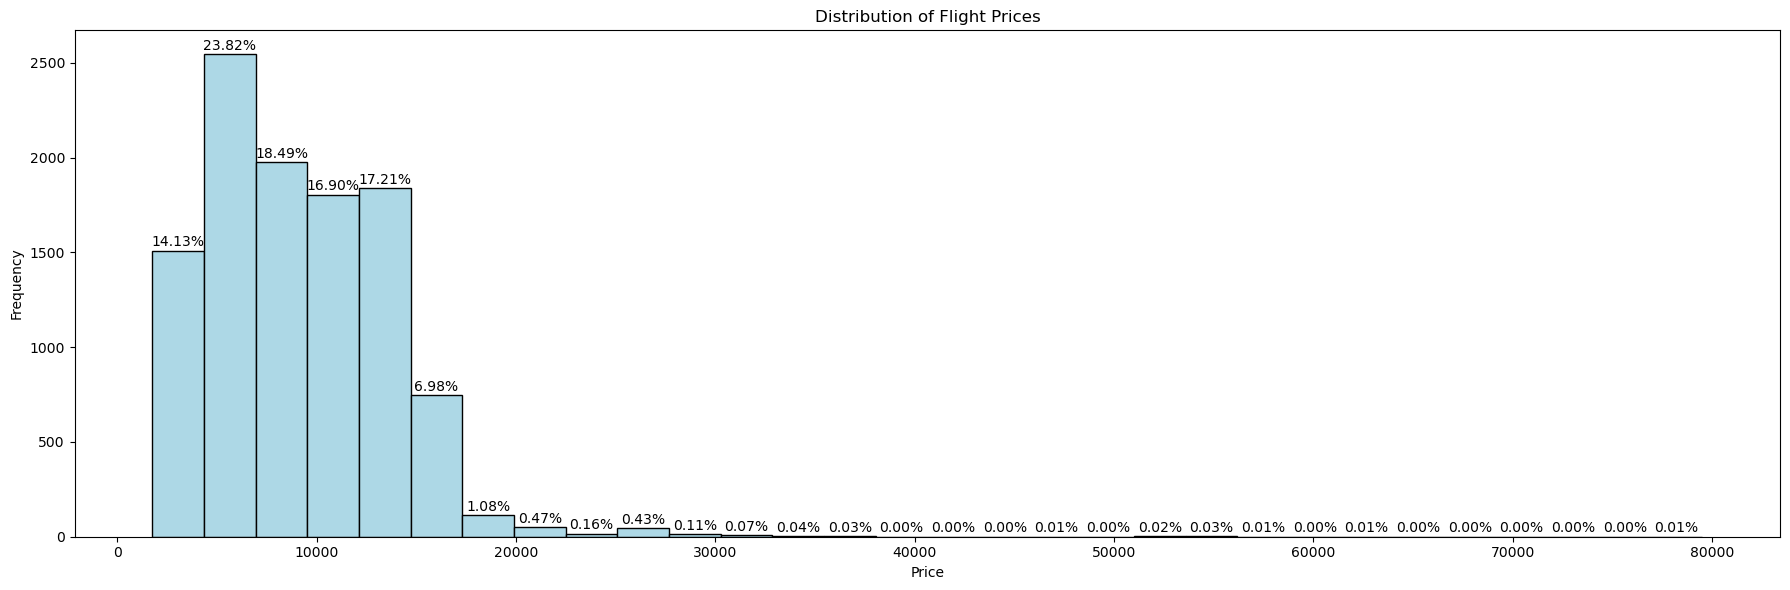

In [17]:
# histogram for flight prices
plt.figure(figsize=(18, 6))
ax = data['Price'].plot(kind='hist', bins=30, color='lightblue', edgecolor='black')
total = len(data)
for p in ax.patches:
    height = p.get_height()
    percentage = f'{height/total*100:.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 6), textcoords='offset points')
plt.title('Distribution of Flight Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

85-90 % flights tickets in are under 15-16 Thousand rupees 

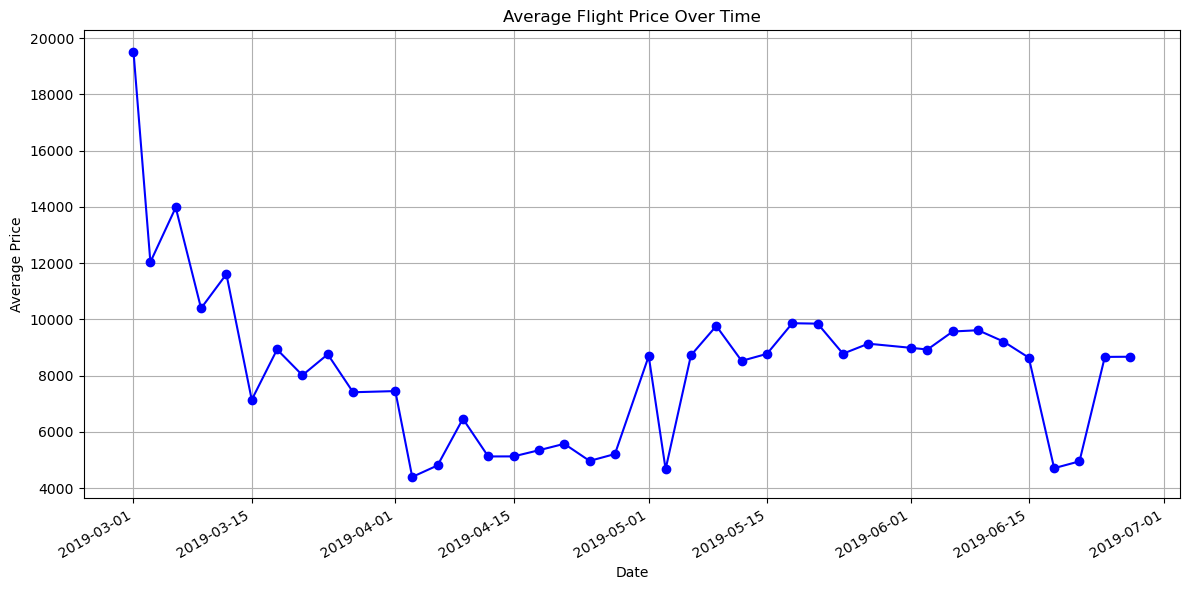

In [19]:
# Convert `Date_of_Journey` to datetime format
data['Date_of_Journey'] = pd.to_datetime(data['Date_of_Journey'], dayfirst=True)

# Group by date and calculate average price
price_by_date = data.groupby('Date_of_Journey')['Price'].mean()

# Create a line plot for average price over time
plt.figure(figsize=(12, 6))
price_by_date.plot(kind='line', marker='o', color='blue')
plt.title('Average Flight Price Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.grid(True)
plt.tight_layout()
plt.show()


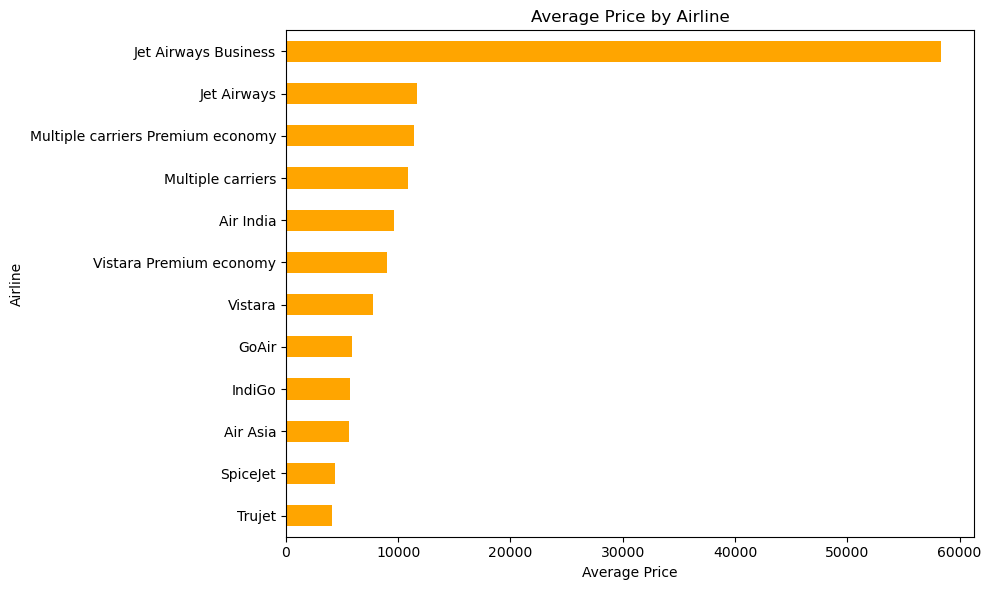

In [20]:
# Group by airline and calculate average price
avg_price_by_airline = data.groupby('Airline')['Price'].mean().sort_values()

# Create a bar plot for average price by airline
plt.figure(figsize=(10, 6))
avg_price_by_airline.plot(kind='barh', color='orange')
plt.title('Average Price by Airline')
plt.xlabel('Average Price')
plt.ylabel('Airline')
plt.tight_layout()
plt.show()

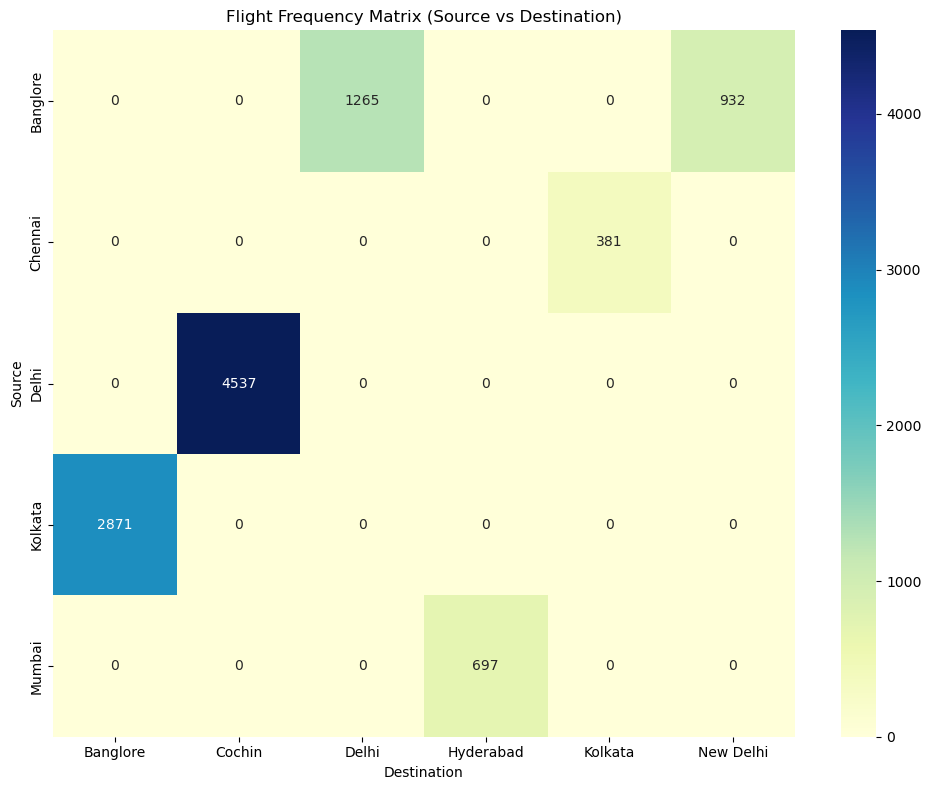

In [21]:
# pivot table to count flights between sources and destinations
flight_matrix = data.pivot_table(index='Source', columns='Destination', aggfunc='size', fill_value=0)

# Create a heatmap for flight frequency
plt.figure(figsize=(10, 8))
sns.heatmap(flight_matrix, annot=True, fmt="d", cmap='YlGnBu')
plt.title('Flight Frequency Matrix (Source vs Destination)')
plt.tight_layout()
plt.show()

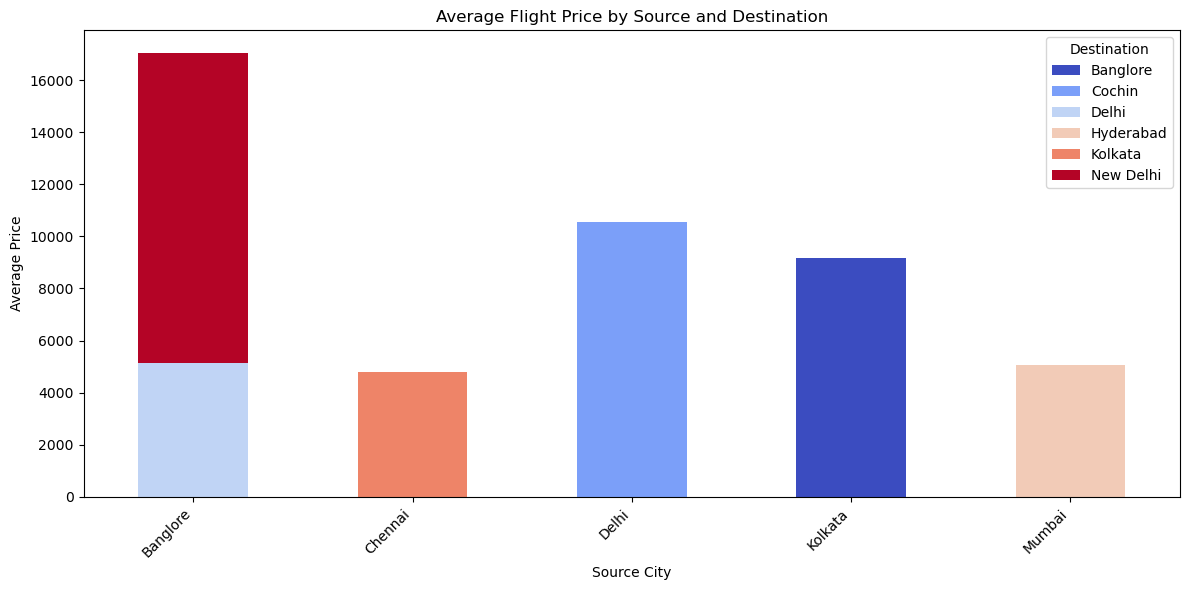

In [22]:
# Group by Source and Destination and calculate average price
avg_price_by_route = data.groupby(['Source', 'Destination'])['Price'].mean().unstack()

# Create a bar plot for average flight price by source and destination
avg_price_by_route.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')
plt.title('Average Flight Price by Source and Destination')
plt.xlabel('Source City')
plt.ylabel('Average Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

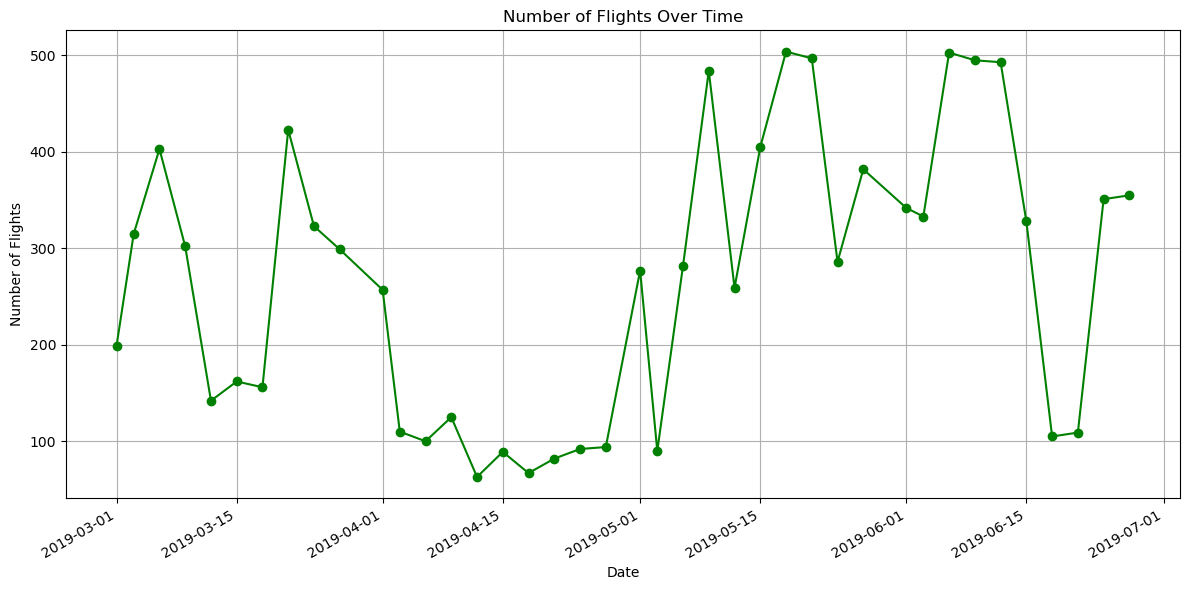

In [23]:
# Group by Date_of_Journey to count flights
flights_by_date = data.groupby('Date_of_Journey').size()

# Create a line plot for the number of flights over time
plt.figure(figsize=(12, 6))
flights_by_date.plot(kind='line', marker='o', color='green')
plt.title('Number of Flights Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Flights')
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# Convert `Date_of_Journey` to datetime format
data['Date_of_Journey'] = pd.to_datetime(data['Date_of_Journey'], dayfirst=True)

In [25]:
# Extract day and month from `Date_of_Journey`
data['Journey_Day'] = data['Date_of_Journey'].dt.day
data['Journey_Month'] = data['Date_of_Journey'].dt.month

In [26]:
# Drop `Date_of_Journey` as it's no longer needed
data.drop('Date_of_Journey', axis=1, inplace=True)

In [27]:
# Extract hours and minutes from `Dep_Time` and `Arrival_Time`
data['Dep_Hour'] = pd.to_datetime(data['Dep_Time']).dt.hour
data['Dep_Minute'] = pd.to_datetime(data['Dep_Time']).dt.minute
data['Arrival_Hour'] = pd.to_datetime(data['Arrival_Time']).dt.hour
data['Arrival_Minute'] = pd.to_datetime(data['Arrival_Time']).dt.minute

In [28]:
# Drop original `Dep_Time` and `Arrival_Time`
data.drop(['Dep_Time', 'Arrival_Time'], axis=1, inplace=True)

In [29]:
# Handle Duration - converting into minutes
duration = data['Duration'].str.extract(r'(?:(\d+)h)?\s*(?:(\d+)m)?').fillna(0).astype(int)
data['Duration_Minutes'] = duration[0] * 60 + duration[1]

In [30]:
# Drop the original `Duration` column
data.drop('Duration', axis=1, inplace=True)

In [31]:
# Fill missing values in `Route` and `Total_Stops`
data['Route'].fillna('Unknown', inplace=True)
data['Total_Stops'].fillna('non-stop', inplace=True)

In [32]:
# Encode categorical columns
categorical_cols = ['Airline', 'Source', 'Destination', 'Route', 'Total_Stops', 'Additional_Info']
numerical_cols = ['Journey_Day', 'Journey_Month', 'Dep_Hour', 'Dep_Minute', 'Arrival_Hour', 'Arrival_Minute', 'Duration_Minutes']

In [33]:
# Pipeline for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

In [34]:
# Split the data into features and target
X = data.drop('Price', axis=1)  
y = data['Price']  

In [115]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [117]:
# Define models
models = {
    'Linear Regression' : LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regressor': SVR(kernel='rbf')
}

In [119]:
# Dictionary to store results
results = {}

In [121]:
# Train and evaluate each model
for model_name, model_instance in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model_instance)])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[model_name] = {'MSE': mse, 'R2': r2}

In [123]:
results

{'Linear Regression': {'MSE': 5432488.9458245905, 'R2': 0.7433142289336361},
 'Random Forest': {'MSE': 2312415.362735533, 'R2': 0.8907380896070319},
 'Gradient Boosting': {'MSE': 3794272.1262606476, 'R2': 0.8207201752129853},
 'Support Vector Regressor': {'MSE': 20486871.25288421,
  'R2': 0.031992812737201226}}

In [40]:
results_df = {
    "Model": ["Linear Regression Regressor","Random Forest Regressor", "Gradient Boosting Regressor", "Support Vector Regressor"],
    "Mean Squared Error (MSE)": [5432488.9458245905, 2312415.362735533, 3794272.1262606476, 20486871.25288421],
    "R-Squared (R²)": [0.7433142289336361, 0.8907380896070319, 0.8207201752129853, 0.031992812737201226]
}

In [41]:
# Convert to DataFrame
df = pd.DataFrame(results_df)

# Save as CSV in the same folder
df.to_csv("Model.csv", index=False)

In [42]:
result = pd.read_csv("Model.csv")

In [43]:
result

,Model,Mean Squared Error (MSE),R-Squared (R²)
0,Linear Regression Regressor,5.432489e+06,0.743314
1,Random Forest Regressor,2.312415e+06,0.890738
2,Gradient Boosting Regressor,3.794272e+06,0.820720
3,Support Vector Regressor,2.048687e+07,0.031993


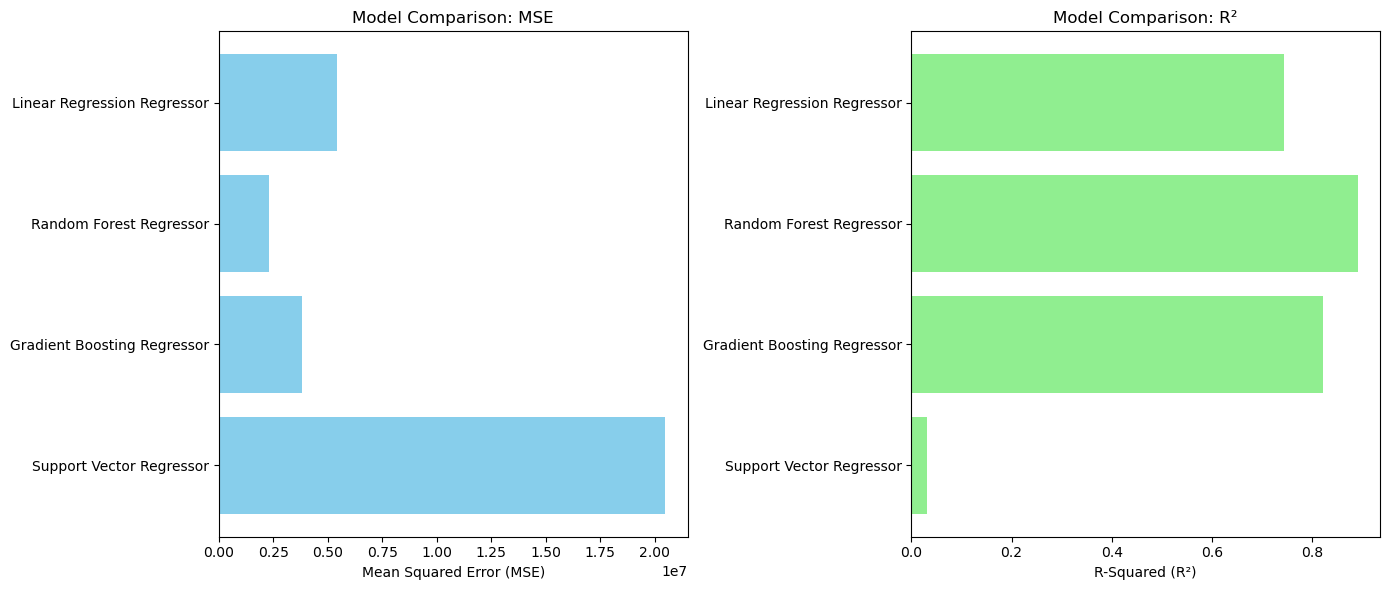

In [44]:
# Performance metrics
models = ["Linear Regression Regressor","Random Forest Regressor", "Gradient Boosting Regressor", "Support Vector Regressor"]
mse = [5432488, 2312415, 3794272, 20486871]
r2 = [0.743, 0.891, 0.821, 0.032]

# Create subplots for MSE and R²
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart for MSE
ax1.barh(models, mse, color='skyblue')
ax1.set_xlabel('Mean Squared Error (MSE)')
ax1.set_title('Model Comparison: MSE')

# Bar chart for R²
ax2.barh(models, r2, color='lightgreen')
ax2.set_xlabel('R-Squared (R²)')
ax2.set_title('Model Comparison: R²')

# Invert y-axis to have the best model at the top
ax1.invert_yaxis()
ax2.invert_yaxis()

# Adjust layout
plt.tight_layout()
plt.show()